In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights
from functools import partial

# Import our custom files
import quantizer
import utils

# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [19]:
import torch.nn as nn
import torch.nn.functional as F

# A simple CNN model designed for MNIST (1 input channel)
class MnistCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) # 1 input channel
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128) # 64 * 12 * 12 = 9216
        self.fc2 = nn.Linear(128, 10) # 10 output classes for digits 0-9

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [20]:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Standard MNIST mean/std
    ])

# Download and load the datasets
trainset = datasets.MNIST('./data', train=True, download=True,
                   transform=transform)
testset = datasets.MNIST('./data', train=False,
                   transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=1000, shuffle=False)

In [5]:
import copy
from tqdm import tqdm

model_fp32 = MnistCNN().to(device)
optimizer = optim.Adam(model_fp32.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 10 # More epochs for high accuracy

print("Training a new FP32 baseline model on MNIST...")
model_fp32.train()
for epoch in range(num_epochs):
    for data, target in tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model_fp32(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} complete.")
print("Finished Training.")

Training a new FP32 baseline model on MNIST...


Epoch 1/10: 100%|██████████| 938/938 [00:05<00:00, 171.97it/s]


Epoch 1 complete.


Epoch 2/10: 100%|██████████| 938/938 [00:05<00:00, 183.18it/s]


Epoch 2 complete.


Epoch 3/10: 100%|██████████| 938/938 [00:05<00:00, 185.04it/s]


Epoch 3 complete.


Epoch 4/10: 100%|██████████| 938/938 [00:05<00:00, 182.00it/s]


Epoch 4 complete.


Epoch 5/10: 100%|██████████| 938/938 [00:05<00:00, 183.07it/s]


Epoch 5 complete.


Epoch 6/10: 100%|██████████| 938/938 [00:05<00:00, 182.14it/s]


Epoch 6 complete.


Epoch 7/10: 100%|██████████| 938/938 [00:05<00:00, 185.54it/s]


Epoch 7 complete.


Epoch 8/10: 100%|██████████| 938/938 [00:04<00:00, 189.90it/s]


Epoch 8 complete.


Epoch 9/10: 100%|██████████| 938/938 [00:04<00:00, 189.71it/s]


Epoch 9 complete.


Epoch 10/10: 100%|██████████| 938/938 [00:05<00:00, 184.80it/s]

Epoch 10 complete.
Finished Training.


In [6]:
from functools import partial

# --- 1. Evaluate our new FP32 baseline ---
# We reuse the `evaluate_resnet` function, but change the printout
fp32_accuracy = utils.evaluate_resnet(model_fp32, testloader, device)

# --- 2. Create a deep copy for quantization ---
model_af_8bit = copy.deepcopy(model_fp32).to(device)

# --- 3. Define and apply 8-bit AdaptivFloat ---
quant_8bit_af_func = partial(quantizer.quantize_to_adaptivfloat,
                             total_bits=8,
                             exponent_bits=3)
quant_8bit_af_func.__name__ = "AdaptivFloat_8bit"
utils.apply_quantization_to_model(model_af_8bit, quant_8bit_af_func)

# --- 4. Evaluate the quantized model ---
af_8bit_accuracy = utils.evaluate_resnet(model_af_8bit, testloader, device)

# --- 5. Print the final, report-ready comparison ---
print("\n--- MNIST Sanity Check Complete ---")
print(f"Baseline FP32 Accuracy (MnistCNN):   {fp32_accuracy:.2f}%")
print(f"AdaptivFloat 8-bit Accuracy (MnistCNN): {af_8bit_accuracy:.2f}%")
print(f"Accuracy Drop: {fp32_accuracy - af_8bit_accuracy:.4f}%")

Evaluating ResNet...


100%|██████████| 10/10 [00:00<00:00, 13.57it/s]


Applying quantization with AdaptivFloat_8bit...
Quantization complete.
Evaluating ResNet...


100%|██████████| 10/10 [00:00<00:00, 14.41it/s]


--- MNIST Sanity Check Complete ---
Baseline FP32 Accuracy (MnistCNN):   99.15%
AdaptivFloat 8-bit Accuracy (MnistCNN): 99.15%
Accuracy Drop: 0.0000%


In [2]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Load BERT tokenizer and model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# The test sentence. The correct answer is "paris"
sentence = "The capital of France is [MASK]."

/scratch/dt/adaptivfloat/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load a fresh FP32 model
model_bert_fp32 = AutoModelForMaskedLM.from_pretrained(model_name).to(device)

# Run the evaluation
predicted_token = utils.evaluate_bert(model_bert_fp32, tokenizer, sentence, device)
print(f"\n[FP32 Baseline BERT] Prediction for '[MASK]': '{predicted_token}'")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



[FP32 Baseline BERT] Prediction for '[MASK]': 'paris'


In [4]:
# Load a fresh model
model_bert_int8 = AutoModelForMaskedLM.from_pretrained(model_name).to(device)

# Create the "bad" INT8 quantizer function
quant_int8_func = partial(utils.simple_int8_quantizer, total_bits=8)
quant_int8_func.__name__ = "Simple_INT8"

# Apply this bad quantization
utils.apply_quantization_to_model(model_bert_int8, quant_int8_func)

# Evaluate
predicted_token_int8 = utils.evaluate_bert(model_bert_int8, tokenizer, sentence, device)
print(f"\n[Simple INT8 BERT] Prediction for '[MASK]': '{predicted_token_int8}'")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Applying quantization with Simple_INT8...
Quantization complete.

[Simple INT8 BERT] Prediction for '[MASK]': '.'


In [10]:
# Load a fresh model
model_bert_af8 = AutoModelForMaskedLM.from_pretrained(model_name).to(device)

# Apply our GOOD AdaptivFloat 8-bit quantizer
# We re-use the function from the ResNet test
utils.apply_quantization_to_model(model_bert_af8, quant_8bit_af_func)

# Evaluate
predicted_token_af8 = utils.evaluate_bert(model_bert_af8, tokenizer, sentence, device)
print(f"\n[AdaptivFloat 8-bit BERT] Prediction for '[MASK]': '{predicted_token_af8}'")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Applying quantization with AdaptivFloat_8bit...
Quantization complete.

[AdaptivFloat 8-bit BERT] Prediction for '[MASK]': 'paris'


In [11]:
print("\n--- Advanced Test: Going to lower bit-widths ---")

# --- 6-bit (3 exp bits) ---
model_bert_af6 = AutoModelForMaskedLM.from_pretrained(model_name).to(device)
quant_6bit_af_func = partial(quantizer.quantize_to_adaptivfloat, total_bits=6, exponent_bits=3)
quant_6bit_af_func.__name__ = "AdaptivFloat_6bit_3exp"
utils.apply_quantization_to_model(model_bert_af6, quant_6bit_af_func)
predicted_token_af6 = utils.evaluate_bert(model_bert_af6, tokenizer, sentence, device)
print(f"[AdaptivFloat 6-bit BERT] Prediction for '[MASK]': '{predicted_token_af6}'")

# --- 4-bit (2 exp bits) ---
model_bert_af4 = AutoModelForMaskedLM.from_pretrained(model_name).to(device)
quant_4bit_af_func = partial(quantizer.quantize_to_adaptivfloat, total_bits=4, exponent_bits=2)
quant_4bit_af_func.__name__ = "AdaptivFloat_4bit_2exp"
utils.apply_quantization_to_model(model_bert_af4, quant_4bit_af_func)
predicted_token_af4 = utils.evaluate_bert(model_bert_af4, tokenizer, sentence, device)
print(f"[AdaptivFloat 4-bit BERT] Prediction for '[MASK]': '{predicted_token_af4}'")


--- Advanced Test: Going to lower bit-widths ---


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Applying quantization with AdaptivFloat_6bit_3exp...
Quantization complete.
[AdaptivFloat 6-bit BERT] Prediction for '[MASK]': 'paris'


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Applying quantization with AdaptivFloat_4bit_2exp...
Quantization complete.
[AdaptivFloat 4-bit BERT] Prediction for '[MASK]': ','


In [12]:
import copy
from functools import partial
import quantizer
import utils
from transformers import AutoModelForMaskedLM
import torch
import torch.nn as nn

# --- 1. Define All Bit-Width Configurations to Test ---
# (total_bits, exponent_bits)
bit_configs = [
    (4, 2),  # As in the paper
    (6, 3),  # As in the paper
    (8, 3),  # Your successful 8-bit test
    (10, 5), # Like FP16 range
    (12, 5)  # Like FP16 range, more precision
]

# (Make sure 'model_fp32' (MnistCNN), 'testloader', 'tokenizer',
# 'sentence', and 'device' are all loaded from your previous cells)
print("--- Starting Bit-Width Ablation Study ---")
print(f"Baseline MnistCNN FP32 Accuracy: 99.25%")
print(f"Baseline BERT FP32 Prediction: 'paris'")
print("-" * 40)

# --- 3. Run the Loop ---
for total_bits, exp_bits in bit_configs:
    print(f"\n===== TESTING {total_bits}-bit (exp={exp_bits}) ADAPTIVFLOAT =====")

    # Define the quantization function
    quant_func = partial(quantizer.quantize_to_adaptivfloat,
                         total_bits=total_bits,
                         exponent_bits=exp_bits)
    quant_func.__name__ = f"AdaptivFloat_{total_bits}bit_{exp_bits}exp"

    # --- MNIST TEST ---
    print(f"--- Running MNIST {total_bits}-bit Test ---")
    model_mnist_quant = copy.deepcopy(model_fp32).to(device)

    try:
        utils.apply_quantization_to_model(model_mnist_quant, quant_func)
        acc = utils.evaluate_resnet(model_mnist_quant, testloader, device)
        print(f"[Result] MnistCNN {total_bits}-bit Accuracy: {acc:.2f}%")

    except ValueError as e:
        print(f"[Result] MnistCNN {total_bits}-bit: FAILED ({e})")

    # --- BERT TEST ---
    print(f"\n--- Running BERT {total_bits}-bit Test ---")
    model_bert_quant = AutoModelForMaskedLM.from_pretrained("bert-base-uncased").to(device)

    try:
        # We must re-apply to a fresh model each time
        utils.apply_quantization_to_model(model_bert_quant, quant_func)
        prediction = utils.evaluate_bert(model_bert_quant, tokenizer, sentence, device)
        print(f"[Result] BERT {total_bits}-bit Prediction: '{prediction}'")

    except ValueError as e:
        print(f"[Result] BERT {total_bits}-bit: FAILED ({e})")

    print("-" * 40)

--- Starting Bit-Width Ablation Study ---
Baseline MnistCNN FP32 Accuracy: 99.25%
Baseline BERT FP32 Prediction: 'paris'
----------------------------------------

===== TESTING 4-bit (exp=2) ADAPTIVFLOAT =====
--- Running MNIST 4-bit Test ---
Applying quantization with AdaptivFloat_4bit_2exp...
Quantization complete.
Evaluating ResNet...


100%|██████████| 10/10 [00:00<00:00, 14.30it/s]


[Result] MnistCNN 4-bit Accuracy: 99.16%

--- Running BERT 4-bit Test ---


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Applying quantization with AdaptivFloat_4bit_2exp...
Quantization complete.
[Result] BERT 4-bit Prediction: ','
----------------------------------------

===== TESTING 6-bit (exp=3) ADAPTIVFLOAT =====
--- Running MNIST 6-bit Test ---
Applying quantization with AdaptivFloat_6bit_3exp...
Quantization complete.
Evaluating ResNet...


100%|██████████| 10/10 [00:00<00:00, 14.51it/s]


[Result] MnistCNN 6-bit Accuracy: 99.12%

--- Running BERT 6-bit Test ---


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Applying quantization with AdaptivFloat_6bit_3exp...
Quantization complete.
[Result] BERT 6-bit Prediction: 'paris'
----------------------------------------

===== TESTING 8-bit (exp=3) ADAPTIVFLOAT =====
--- Running MNIST 8-bit Test ---
Applying quantization with AdaptivFloat_8bit_3exp...
Quantization complete.
Evaluating ResNet...


100%|██████████| 10/10 [00:00<00:00, 14.51it/s]


[Result] MnistCNN 8-bit Accuracy: 99.15%

--- Running BERT 8-bit Test ---


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Applying quantization with AdaptivFloat_8bit_3exp...
Quantization complete.
[Result] BERT 8-bit Prediction: 'paris'
----------------------------------------

===== TESTING 10-bit (exp=5) ADAPTIVFLOAT =====
--- Running MNIST 10-bit Test ---
Applying quantization with AdaptivFloat_10bit_5exp...
Quantization complete.
Evaluating ResNet...


100%|██████████| 10/10 [00:00<00:00, 14.33it/s]


[Result] MnistCNN 10-bit Accuracy: 99.15%

--- Running BERT 10-bit Test ---


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Applying quantization with AdaptivFloat_10bit_5exp...
Quantization complete.
[Result] BERT 10-bit Prediction: 'paris'
----------------------------------------

===== TESTING 12-bit (exp=5) ADAPTIVFLOAT =====
--- Running MNIST 12-bit Test ---
Applying quantization with AdaptivFloat_12bit_5exp...
Quantization complete.
Evaluating ResNet...


100%|██████████| 10/10 [00:00<00:00, 14.59it/s]


[Result] MnistCNN 12-bit Accuracy: 99.15%

--- Running BERT 12-bit Test ---


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Applying quantization with AdaptivFloat_12bit_5exp...
Quantization complete.
[Result] BERT 12-bit Prediction: 'paris'
----------------------------------------


In [5]:
import torch
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification

In [6]:
def plot_confusion_matrix(y_true, y_pred, labels, title):
    """
    Plots a confusion matrix using scikit-learn.
    """
    cm = metrics.confusion_matrix(y_true, y_pred, labels=labels)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='Blues')
    plt.title(title)
    plt.show()

@torch.no_grad()
def get_all_predictions(model, dataloader, device):
    """
    Runs a model over a test dataloader and returns all predictions and labels.
    Handles both list-style (MNIST) and dict-style (BERT) dataloaders.
    """
    model.eval()
    all_preds = []
    all_labels = []
    print("Gathering all predictions for confusion matrix...")

    for batch in tqdm(dataloader, desc="Predicting"):
        # --- 1. Move data to device (Handles both list/dict) ---
        if isinstance(batch, list):
            # MNIST/CIFAR style: batch is [data, labels]
            data, labels = batch
            data, labels = data.to(device), labels.to(device)
            input_data = data
        elif isinstance(batch, dict):
            # BERT/SST-2 style: batch is a dict
            # Find the label key, which might be 'label' or 'labels'
            label_key = 'label' if 'label' in batch else 'labels'
            labels = batch.pop(label_key).to(device)
            # The rest of the batch is model input
            input_data = {k: v.to(device) for k, v in batch.items()}
        else:
            raise TypeError(f"Unknown batch type: {type(batch)}")

        # --- 2. Get Model Output ---
        if isinstance(input_data, dict): # BERT model
            outputs = model(**input_data)
        else: # MNIST/CNN model
            outputs = model(input_data)

        # --- 3. Get Predictions ---
        # For MNIST/CifarCNN, output is raw logits (Tensor)
        if isinstance(outputs, torch.Tensor):
            pred = torch.argmax(outputs, dim=1)
        # For BERT classification, output is an object with a .logits attribute
        else:
            pred = torch.argmax(outputs.logits, dim=1)

        # --- 4. Store results ---
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

Gathering all predictions for confusion matrix...


Predicting:   0%|          | 0/10 [00:00<?, ?it/s]

Predicting: 100%|██████████| 10/10 [00:00<00:00, 14.26it/s]


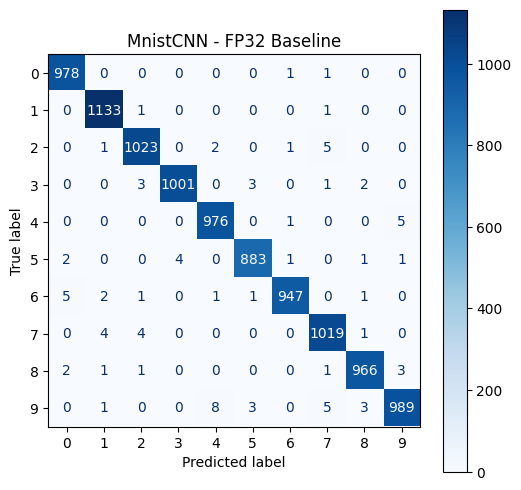

Applying quantization with AdaptivFloat_4bit_2exp...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 14.49it/s]


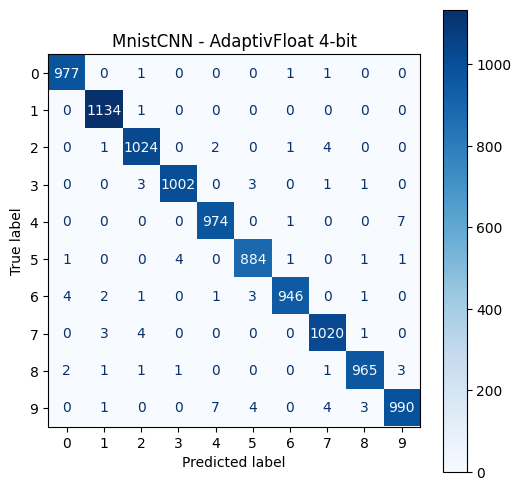

In [15]:
# (Assumes 'model_fp32' (your trained MnistCNN) and 'testloader' are already loaded)
mnist_labels = list(range(10))

# 1. Get FP32 predictions
y_true_mnist, y_pred_mnist_fp32 = get_all_predictions(model_fp32, testloader, device)
plot_confusion_matrix(y_true_mnist, y_pred_mnist_fp32, mnist_labels, "MnistCNN - FP32 Baseline")

# 2. Get 4-bit AdaptivFloat predictions
quant_4bit_func = partial(quantizer.quantize_to_adaptivfloat, total_bits=4, exponent_bits=2)
quant_4bit_func.__name__ = "AdaptivFloat_4bit_2exp"

model_mnist_af4 = copy.deepcopy(model_fp32).to(device)
utils.apply_quantization_to_model(model_mnist_af4, quant_4bit_func)

y_true_mnist, y_pred_mnist_af4 = get_all_predictions(model_mnist_af4, testloader, device)
plot_confusion_matrix(y_true_mnist, y_pred_mnist_af4, mnist_labels, "MnistCNN - AdaptivFloat 4-bit")

--- Generating FP32 Baseline Confusion Matrix ---
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 11.61it/s]


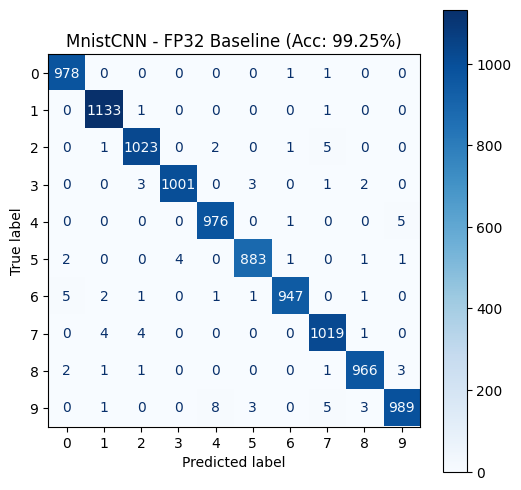


--- Generating Quantized Confusion Matrices ---
Generating matrix for: MnistCNN - AdaptivFloat 4-bit (2 exp)
Applying quantization with AdaptivFloat_4bit_2exp...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 14.54it/s]


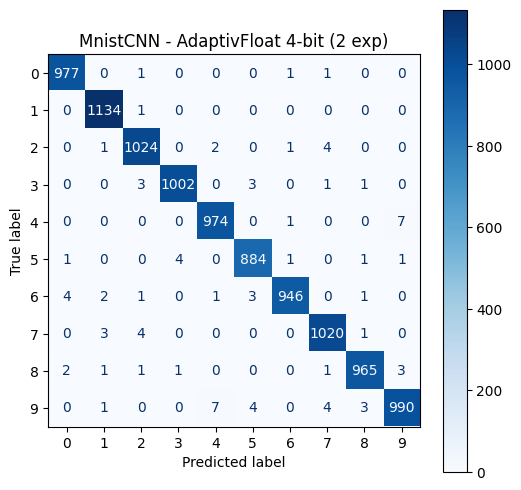

Generating matrix for: MnistCNN - AdaptivFloat 6-bit (3 exp)
Applying quantization with AdaptivFloat_6bit_3exp...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 14.46it/s]


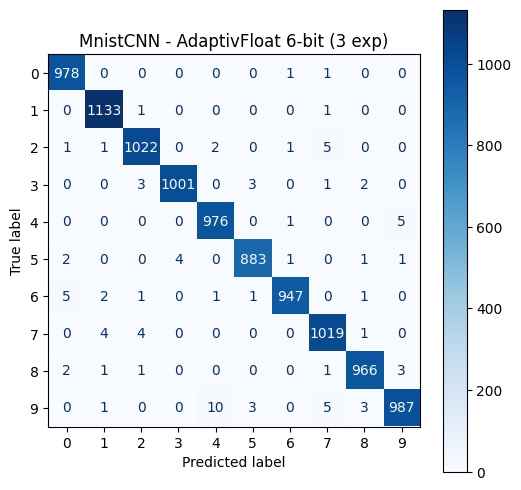

Generating matrix for: MnistCNN - AdaptivFloat 8-bit (3 exp)
Applying quantization with AdaptivFloat_8bit_3exp...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 14.51it/s]


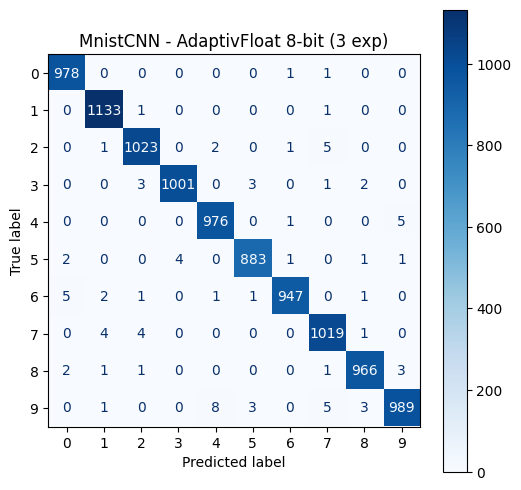

Generating matrix for: MnistCNN - AdaptivFloat 10-bit (5 exp)
Applying quantization with AdaptivFloat_10bit_5exp...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 14.59it/s]


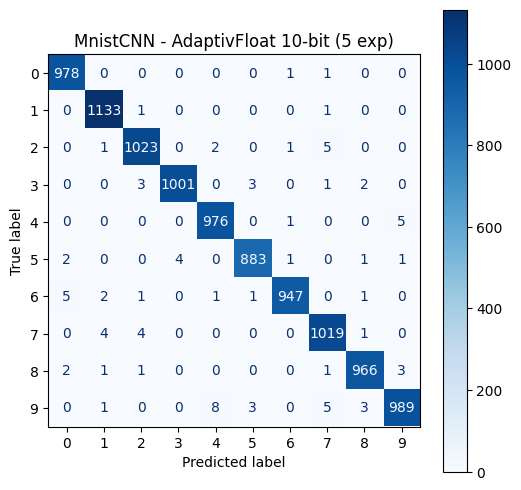

Generating matrix for: MnistCNN - AdaptivFloat 12-bit (5 exp)
Applying quantization with AdaptivFloat_12bit_5exp...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 14.53it/s]


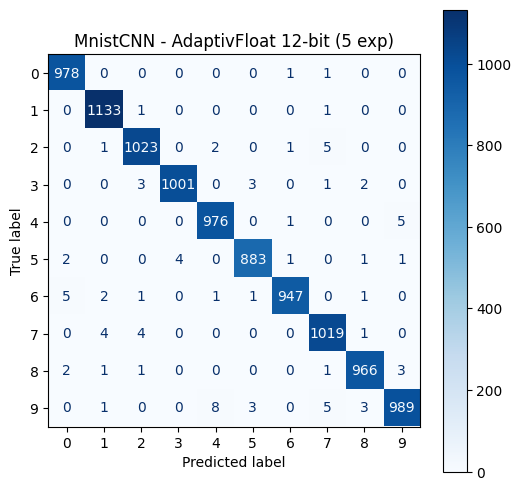

All MNIST confusion matrices generated.


In [16]:
import copy
from functools import partial

# --- 1. Define All Bit-Width Configurations to Test ---
# (total_bits, exponent_bits)
bit_configs = [
    (4, 2),
    (6, 3),
    (8, 3),
    (10, 5),
    (12, 5)
]

mnist_labels = list(range(10)) # Labels are 0-9

# --- 2. Get and Plot Baseline FP32 Predictions (Only once) ---
print("--- Generating FP32 Baseline Confusion Matrix ---")
y_true_mnist, y_pred_mnist_fp32 = get_all_predictions(model_fp32, testloader, device)
plot_confusion_matrix(y_true_mnist, y_pred_mnist_fp32, mnist_labels, "MnistCNN - FP32 Baseline (Acc: 99.25%)")


# --- 3. Loop Through All Bit-Widths and Plot ---
print("\n--- Generating Quantized Confusion Matrices ---")
for total_bits, exp_bits in bit_configs:

    title = f"MnistCNN - AdaptivFloat {total_bits}-bit ({exp_bits} exp)"
    print(f"Generating matrix for: {title}")

    # --- A. Define the quantization function ---
    quant_func = partial(quantizer.quantize_to_adaptivfloat,
                         total_bits=total_bits,
                         exponent_bits=exp_bits)
    quant_func.__name__ = f"AdaptivFloat_{total_bits}bit_{exp_bits}exp"

    # --- B. Create, quantize, and evaluate a fresh model ---
    model_mnist_quant = copy.deepcopy(model_fp32).to(device)
    utils.apply_quantization_to_model(model_mnist_quant, quant_func)

    y_true, y_pred_quant = get_all_predictions(model_mnist_quant, testloader, device)

    # --- C. Plot the confusion matrix ---
    plot_confusion_matrix(y_true, y_pred_quant, mnist_labels, title)

print("All MNIST confusion matrices generated.")

In [7]:
# --- 1. Load Model and Tokenizer for CLASSIFICATION ---
model_name = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
model_bert_fp32_clf = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

# --- 2. Load GLUE SST-2 Dataset ---
dataset = load_dataset("glue", "sst2")
sst2_val = dataset['validation']

# --- 3. Tokenize the dataset ---
def tokenize_sst2(batch):
    return bert_tokenizer(batch['sentence'], padding='max_length', truncation=True, max_length=128)

sst2_val = sst2_val.map(tokenize_sst2, batched=True)

# ---> Fix: rename 'label' to 'labels'
sst2_val = sst2_val.rename_column("label", "labels")

sst2_val.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataloader = DataLoader(sst2_val, batch_size=32, shuffle=False)

sst2_labels = [0, 1] # 0=neg, 1=pos


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:

@torch.no_grad()
def get_all_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    print("Gathering all predictions for confusion matrix...")
    for batch in tqdm(dataloader, desc="Predicting"):
        # move whole batch dict to device
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["labels"]

        outputs = model(**batch)
        pred = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds


def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = metrics.confusion_matrix(y_true, y_pred, labels=labels)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='Blues')
    plt.title(title)
    plt.show()


Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:00<00:00, 28.77it/s]


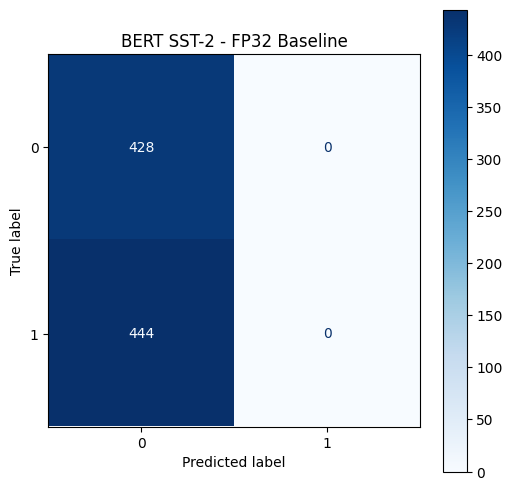

Applying quantization with Simple_INT8...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:00<00:00, 29.43it/s]


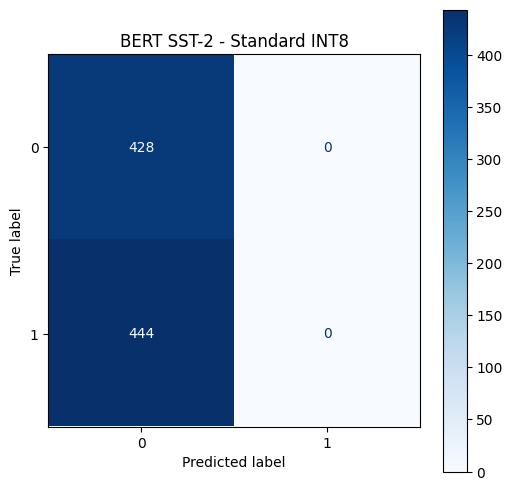

Applying quantization with AdaptivFloat_8bit_3exp...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:00<00:00, 30.57it/s]


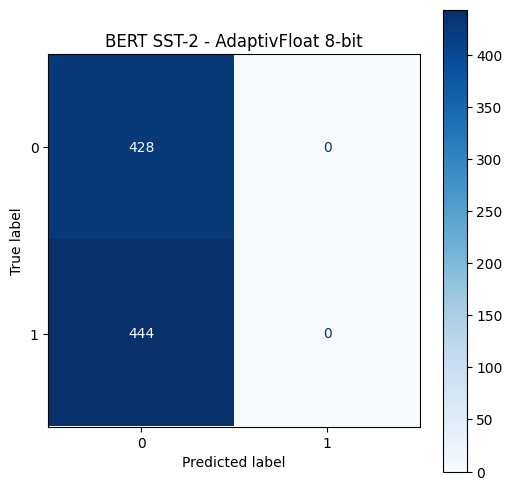

In [11]:
# --- 1. Evaluate FP32 BERT (Classification) ---
from tqdm import tqdm
import copy
y_true_bert, y_pred_bert_fp32 = get_all_predictions(model_bert_fp32_clf, val_dataloader, device)
plot_confusion_matrix(y_true_bert, y_pred_bert_fp32, sst2_labels, "BERT SST-2 - FP32 Baseline")

# --- 2. Evaluate Standard INT8 (Should fail) ---
quant_int8_func = partial(utils.simple_int8_quantizer, total_bits=8)
quant_int8_func.__name__ = "Simple_INT8"

model_bert_int8_clf = copy.deepcopy(model_bert_fp32_clf).to(device)
utils.apply_quantization_to_model(model_bert_int8_clf, quant_int8_func)

y_true_bert, y_pred_bert_int8 = get_all_predictions(model_bert_int8_clf, val_dataloader, device)
plot_confusion_matrix(y_true_bert, y_pred_bert_int8, sst2_labels, "BERT SST-2 - Standard INT8")

# --- 3. Evaluate AdaptivFloat 8-bit (Should pass) ---
quant_8bit_af_func = partial(quantizer.quantize_to_adaptivfloat, total_bits=8, exponent_bits=3)
quant_8bit_af_func.__name__ = "AdaptivFloat_8bit_3exp"

model_bert_af8_clf = copy.deepcopy(model_bert_fp32_clf).to(device)
utils.apply_quantization_to_model(model_bert_af8_clf, quant_8bit_af_func)

y_true_bert, y_pred_bert_af8 = get_all_predictions(model_bert_af8_clf, val_dataloader, device)
plot_confusion_matrix(y_true_bert, y_pred_bert_af8, sst2_labels, "BERT SST-2 - AdaptivFloat 8-bit")


In [15]:
import pandas as pd

# This dictionary will store our activation ranges
activation_ranges = {}

def get_activation_ranges_hook(name):
    """
    This is the hook function that will be called.
    It logs the min/max of a layer's output (activation).
    """
    def hook(model, input, output):
        # Detach output to save memory
        output_data = output.detach().cpu()
        activation_ranges[name] = [output_data.min().item(), output_data.max().item()]
    return hook

@torch.no_grad()
def log_activation_ranges(model, dataloader, device):
    """
    Attaches hooks to a model, runs one batch, and returns the ranges.
    """
    model.eval()
    activation_ranges.clear() # Clear any old data
    hooks = [] # To store hook handles

    # --- Attach hooks to all relevant layers ---
    # We look for layers that produce activations
    for name, module in model.named_modules():
        if isinstance(module, (nn.ReLU, nn.Linear, nn.Conv2d, nn.GELU)):
            hooks.append(
                module.register_forward_hook(get_activation_ranges_hook(name))
            )

    print(f"Logging activation ranges for {model.__class__.__name__}...")
    # --- Run one batch of data to trigger the hooks ---
    try:
        batch = next(iter(dataloader))
        # Dataloader gives different formats
        if isinstance(batch, list): # Cifar/MNIST
            data = batch[0].to(device)
            model(data)
        else: # BERT/SST-2
            # Move all items in the batch dict to device
            batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
            model(**batch)

    except Exception as e:
        print(f"Error during hook forward pass: {e}")

    # --- Remove all hooks ---
    for h in hooks:
        h.remove()

    print("Logging complete.")
    # --- Format and return the results ---
    df = pd.DataFrame.from_dict(
        activation_ranges,
        orient='index',
        columns=['Min', 'Max']
    )
    df['Dynamic Range (Max - Min)'] = df['Max'] - df['Min']
    return df.sort_values(by='Dynamic Range (Max - Min)', ascending=False)

In [16]:
# (Assumes 'model_fp32' (MnistCNN) and 'testloader' are loaded)
mnist_ranges_df = log_activation_ranges(model_fp32, testloader, device)

print("\n--- MnistCNN (FP32) Activation Ranges ---")
print(mnist_ranges_df)

NameError: name 'model_fp32' is not defined

In [17]:
# (Assumes 'model_bert_fp32_clf' (SST-2 model) and 'val_dataloader' are loaded)
bert_ranges_df = log_activation_ranges(model_bert_fp32_clf, val_dataloader, device)

print("\n--- BERT (FP32) Activation Ranges ---")
print(bert_ranges_df.head(20)) # Print top 20 largest ranges

NameError: name 'nn' is not defined

In [12]:
from torch.optim import AdamW
from tqdm import tqdm

# --- 1. Load SST-2 Training Data ---
sst2_train = dataset['train'].map(tokenize_sst2, batched=True)
sst2_train = sst2_train.rename_column("label", "labels")   # keep consistent with eval code
sst2_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
train_dataloader = DataLoader(sst2_train, batch_size=16, shuffle=True)

# --- 2. Setup Optimizer ---
model_bert_fp32_clf.train()
optimizer = AdamW(model_bert_fp32_clf.parameters(), lr=2e-5)
num_epochs = 2

print("--- Fine-Tuning FP32 BERT on SST-2 ---")

for epoch in range(num_epochs):
    print(f"Starting Epoch {epoch + 1}/{num_epochs}")
    for batch in tqdm(train_dataloader, desc="Training"):
        optimizer.zero_grad()

        # move batch
        batch = {k: v.to(device) for k,v in batch.items()}

        outputs = model_bert_fp32_clf(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1} complete. Loss: {loss.item()}")

print("--- Fine-Tuning Complete ---")
model_bert_fp32_clf.eval()


--- Fine-Tuning FP32 BERT on SST-2 ---
Starting Epoch 1/2


Training: 100%|██████████| 4210/4210 [04:12<00:00, 16.67it/s]


Epoch 1 complete. Loss: 0.07301177084445953
Starting Epoch 2/2


Training: 100%|██████████| 4210/4210 [04:12<00:00, 16.67it/s]

Epoch 2 complete. Loss: 0.008166291750967503
--- Fine-Tuning Complete ---


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

--- Generating FP32 Baseline (FINETUNED) BERT Matrix ---
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:00<00:00, 28.07it/s]


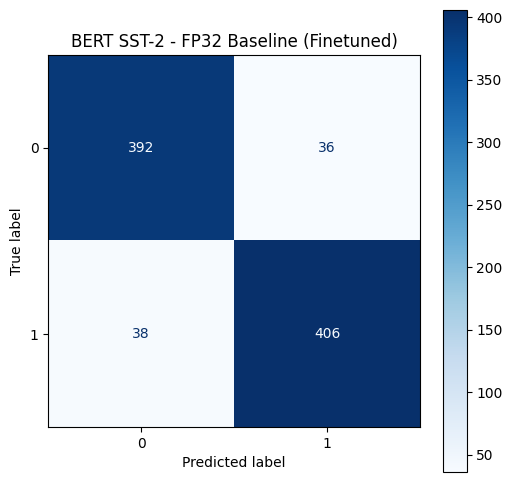


--- Generating Standard INT8 BERT Matrix ---
Applying quantization with Simple_INT8...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:01<00:00, 27.96it/s]


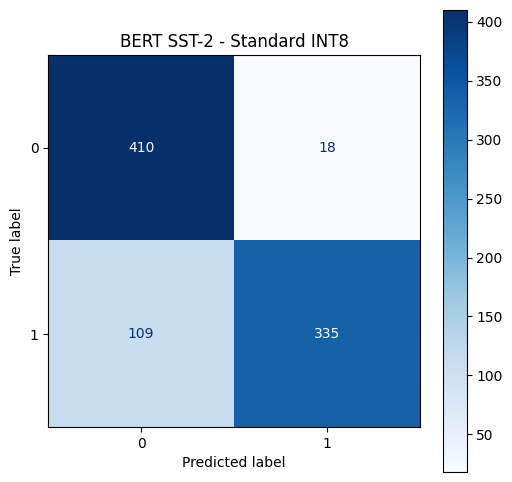


--- Generating Quantized AdaptivFloat BERT Matrices ---
Generating matrix for: BERT SST-2 - AdaptivFloat 4-bit (2 exp)
Applying quantization with AdaptivFloat_4bit_2exp...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:00<00:00, 30.33it/s]


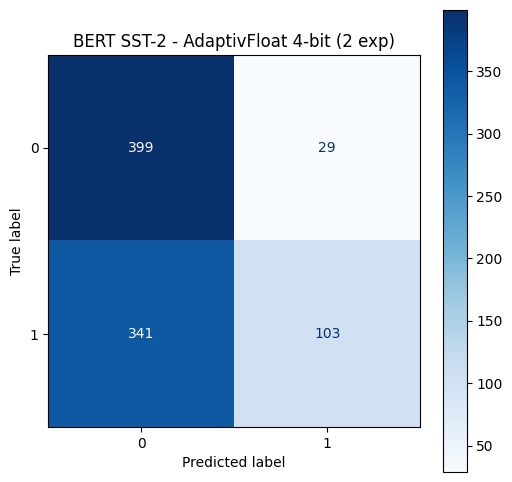

Generating matrix for: BERT SST-2 - AdaptivFloat 6-bit (3 exp)
Applying quantization with AdaptivFloat_6bit_3exp...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:00<00:00, 28.82it/s]


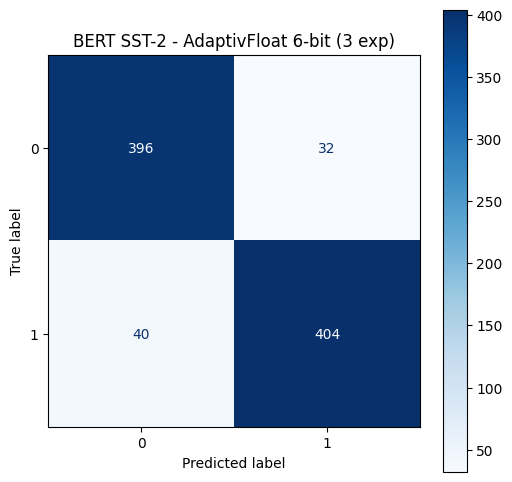

Generating matrix for: BERT SST-2 - AdaptivFloat 8-bit (3 exp)
Applying quantization with AdaptivFloat_8bit_3exp...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:00<00:00, 28.31it/s]


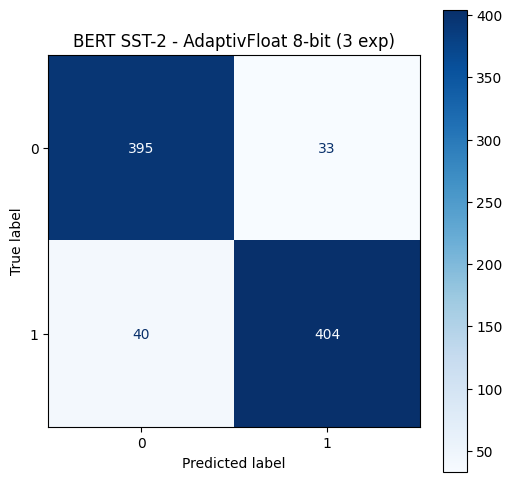

Generating matrix for: BERT SST-2 - AdaptivFloat 10-bit (5 exp)
Applying quantization with AdaptivFloat_10bit_5exp...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:00<00:00, 28.61it/s]


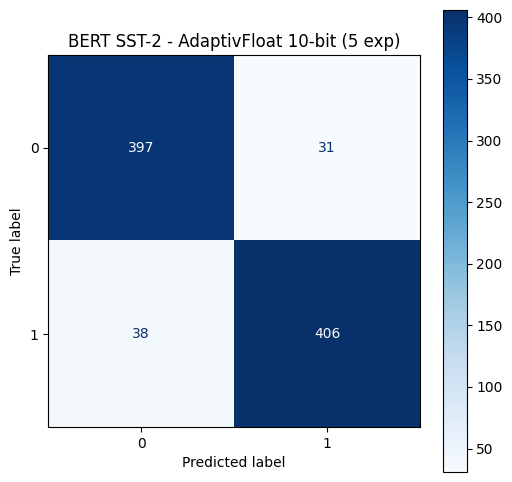

All BERT confusion matrices generated.


In [13]:
import copy
from functools import partial

# --- 1. Define All Bit-Width Configurations to Test ---
# (total_bits, exponent_bits)
bit_configs = [
    (4, 2),
    (6, 3),
    (8, 3),
    (10, 5)
]

sst2_labels = [0, 1] # 0 = negative, 1 = positive

# --- 2. Get and Plot Baseline FP32 Predictions (Only once) ---
print("--- Generating FP32 Baseline (FINETUNED) BERT Matrix ---")
# (This assumes 'model_bert_fp32_clf' is your FINETUNED model)
y_true_bert, y_pred_bert_fp32 = get_all_predictions(model_bert_fp32_clf, val_dataloader, device)
plot_confusion_matrix(y_true_bert, y_pred_bert_fp32, sst2_labels, "BERT SST-2 - FP32 Baseline (Finetuned)")

# --- 3. Get and Plot Standard INT8 (Only once) ---
print("\n--- Generating Standard INT8 BERT Matrix ---")
quant_int8_func = partial(utils.simple_int8_quantizer, total_bits=8)
quant_int8_func.__name__ = "Simple_INT8"

# We must quantize a DEEP COPY of the finetuned model
model_bert_int8_clf = copy.deepcopy(model_bert_fp32_clf).to(device)
utils.apply_quantization_to_model(model_bert_int8_clf, quant_int8_func)

y_true_bert_int8, y_pred_bert_int8 = get_all_predictions(model_bert_int8_clf, val_dataloader, device)
plot_confusion_matrix(y_true_bert_int8, y_pred_bert_int8, sst2_labels, "BERT SST-2 - Standard INT8")


# --- 4. Loop Through All AdaptivFloat Bit-Widths and Plot ---
print("\n--- Generating Quantized AdaptivFloat BERT Matrices ---")
for total_bits, exp_bits in bit_configs:

    title = f"BERT SST-2 - AdaptivFloat {total_bits}-bit ({exp_bits} exp)"
    print(f"Generating matrix for: {title}")

    # --- A. Define the quantization function ---
    quant_func = partial(quantizer.quantize_to_adaptivfloat,
                         total_bits=total_bits,
                         exponent_bits=exp_bits)
    quant_func.__name__ = f"AdaptivFloat_{total_bits}bit_{exp_bits}exp"

    # --- B. Create, quantize, and evaluate a fresh model ---
    # We must DEEP COPY the finetuned model *every time*
    model_bert_quant = copy.deepcopy(model_bert_fp32_clf).to(device)
    utils.apply_quantization_to_model(model_bert_quant, quant_func)

    y_true, y_pred_quant = get_all_predictions(model_bert_quant, val_dataloader, device)

    # --- C. Plot the confusion matrix ---
    plot_confusion_matrix(y_true, y_pred_quant, sst2_labels, title)

print("All BERT confusion matrices generated.")

In [21]:
# (Assumes 'model_bert_fp32_clf' (SST-2 model) and 'val_dataloader' are loaded)
bert_ranges_df = log_activation_ranges(model_bert_fp32_clf, val_dataloader, device)

print("\n--- BERT (FP32) Activation Ranges ---")
print(bert_ranges_df.head(20)) # Print top 20 largest ranges

Logging activation ranges for BertForSequenceClassification...
Logging complete.

--- BERT (FP32) Activation Ranges ---
                                                  Min         Max  \
bert.encoder.layer.9.output.dense         -728.044006  499.956207   
bert.encoder.layer.10.output.dense       -1062.132080   33.048210   
bert.encoder.layer.2.output.dense         -250.096512    5.958576   
bert.encoder.layer.8.output.dense         -166.875916   48.364746   
bert.encoder.layer.10.intermediate.dense   -32.659039  141.365555   
bert.encoder.layer.9.intermediate.dense    -38.647209   93.863144   
bert.encoder.layer.3.output.dense         -116.006104    4.888508   
bert.encoder.layer.4.output.dense          -97.392914    4.211280   
bert.encoder.layer.2.intermediate.dense    -24.258896   60.605171   
bert.encoder.layer.5.output.dense          -76.933556    3.185477   
bert.encoder.layer.4.intermediate.dense    -61.316238   12.352815   
bert.encoder.layer.3.intermediate.dense    -60.64552

Compare DistilBERT, ALBERT, and BERT-base



==================== STARTING ANALYSIS FOR: BERT-base ====================
Loading bert-base-uncased...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1821/1821 [00:00<00:00, 20065.22 examples/s]


--- Logging FP32 Activation Ranges for BERT-base ---
Logging activation ranges for BertForSequenceClassification...
Logging complete.
                                                 Min         Max  \
bert.encoder.layer.9.output.dense        -636.262390  445.114441   
bert.encoder.layer.10.output.dense       -996.056580   34.451675   
bert.encoder.layer.2.output.dense        -232.325333    5.272179   
bert.encoder.layer.10.intermediate.dense  -32.684807  133.184128   
bert.encoder.layer.9.intermediate.dense   -44.565327   79.555641   
bert.encoder.layer.8.output.dense         -71.440117   24.905693   
bert.encoder.layer.4.output.dense         -83.301697    4.071802   
bert.encoder.layer.3.output.dense         -82.186340    4.607460   
bert.encoder.layer.2.intermediate.dense   -23.240749   55.947308   
bert.encoder.layer.0.output.dense         -62.293274   16.873459   

                                          Dynamic Range (Max - Min)  
bert.encoder.layer.9.output.dense              

Training: 100%|██████████| 4210/4210 [04:12<00:00, 16.68it/s]


Epoch 1 complete. Loss: 0.09868384152650833
Starting Epoch 2/2


Training: 100%|██████████| 4210/4210 [04:15<00:00, 16.51it/s]


Epoch 2 complete. Loss: 0.22080139815807343
Fine-Tuning Complete.

--- Generating Confusion Matrices for BERT-base ---
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:01<00:00, 26.62it/s]


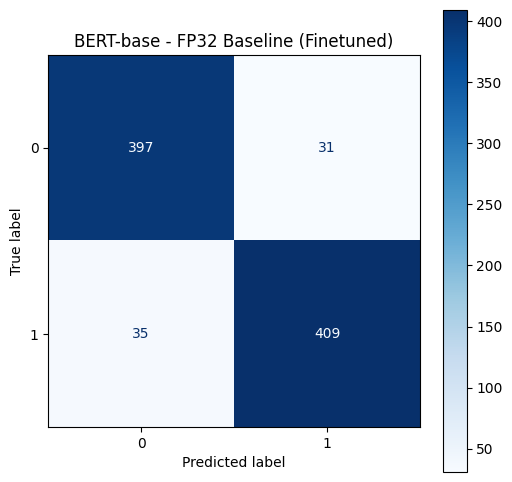

Applying quantization with Simple_INT8...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:01<00:00, 27.61it/s]


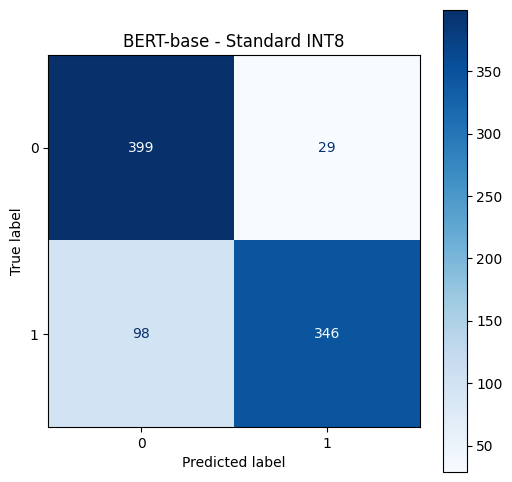

Applying quantization with AdaptivFloat_8bit_3exp...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:00<00:00, 28.20it/s]


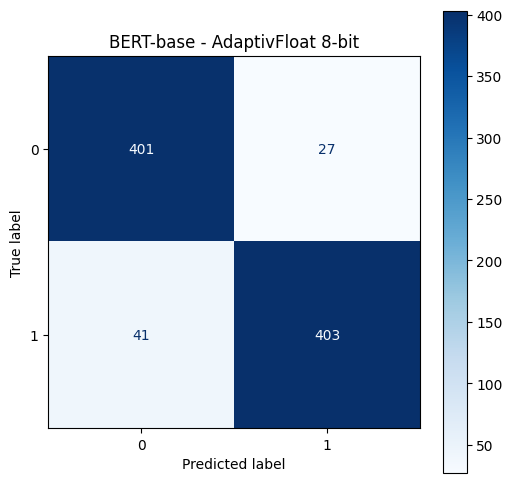


==================== COMPLETED ANALYSIS FOR: BERT-base ====================


==================== STARTING ANALYSIS FOR: DistilBERT ====================
Loading distilbert-base-uncased...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1821/1821 [00:00<00:00, 22878.02 examples/s]


--- Logging FP32 Activation Ranges for DistilBERT ---
Logging activation ranges for DistilBertForSequenceClassification...
Logging complete.
                                                Min         Max  \
distilbert.transformer.layer.4.ffn.lin2 -778.732788  404.420349   
distilbert.transformer.layer.2.ffn.lin2 -246.156982    3.726555   
distilbert.transformer.layer.1.ffn.lin2 -190.347519    5.207352   
distilbert.transformer.layer.4.ffn.lin1  -32.027328   71.307083   
distilbert.transformer.layer.0.ffn.lin2  -76.023521   13.722200   
distilbert.transformer.layer.2.ffn.lin1  -55.064167   24.537176   
distilbert.transformer.layer.1.ffn.lin1  -19.839035   36.604805   
distilbert.transformer.layer.5.ffn.lin2  -39.690411   14.017709   
distilbert.transformer.layer.0.ffn.lin1  -19.233942   18.206011   
distilbert.transformer.layer.5.ffn.lin1  -21.008265    8.999809   

                                         Dynamic Range (Max - Min)  
distilbert.transformer.layer.4.ffn.lin2             

Training: 100%|██████████| 4210/4210 [02:07<00:00, 32.92it/s]


Epoch 1 complete. Loss: 0.0629197508096695
Starting Epoch 2/2


Training: 100%|██████████| 4210/4210 [02:08<00:00, 32.79it/s]


Epoch 2 complete. Loss: 0.006962648592889309
Fine-Tuning Complete.

--- Generating Confusion Matrices for DistilBERT ---
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:00<00:00, 54.37it/s]


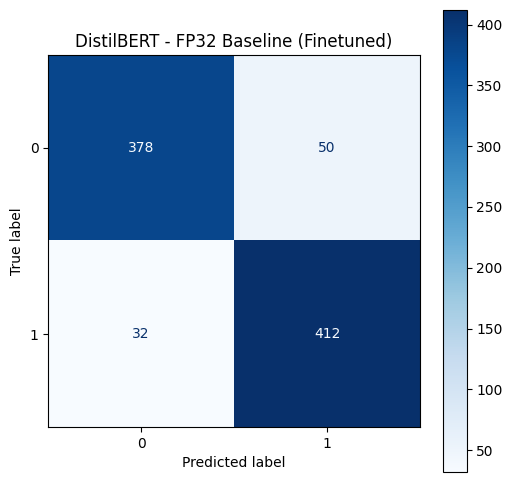

Applying quantization with Simple_INT8...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:00<00:00, 56.53it/s]


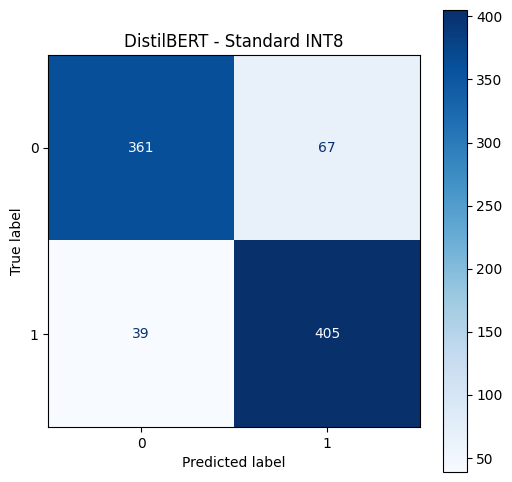

Applying quantization with AdaptivFloat_8bit_3exp...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:00<00:00, 59.17it/s]


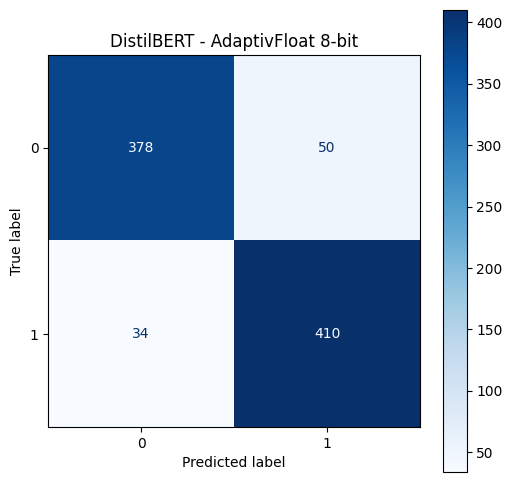


==================== COMPLETED ANALYSIS FOR: DistilBERT ====================


==================== STARTING ANALYSIS FOR: ALBERT ====================
Loading albert-base-v2...


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1821/1821 [00:00<00:00, 16626.42 examples/s]


--- Logging FP32 Activation Ranges for ALBERT ---
Logging activation ranges for AlbertForSequenceClassification...
Logging complete.
                                                          Min        Max  \
albert.encoder.albert_layer_groups.0.albert_lay... -31.563995  48.824409   
albert.encoder.albert_layer_groups.0.albert_lay... -67.429413   7.229234   
albert.encoder.albert_layer_groups.0.albert_lay... -30.984304  22.997768   
albert.encoder.albert_layer_groups.0.albert_lay... -10.176170  11.642714   
albert.encoder.albert_layer_groups.0.albert_lay...  -9.606884  11.631409   
albert.pooler                                       -9.095490  10.113943   
albert.encoder.albert_layer_groups.0.albert_lay...  -7.851250   8.797873   
albert.encoder.embedding_hidden_mapping_in          -7.284079   7.748002   
classifier                                          -0.324544   0.966879   

                                                    Dynamic Range (Max - Min)  
albert.encoder.albert_laye

Training: 100%|██████████| 4210/4210 [04:09<00:00, 16.89it/s]


Epoch 1 complete. Loss: 0.2011910378932953
Starting Epoch 2/2


Training: 100%|██████████| 4210/4210 [04:04<00:00, 17.21it/s]


Epoch 2 complete. Loss: 0.1060149297118187
Fine-Tuning Complete.

--- Generating Confusion Matrices for ALBERT ---
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:01<00:00, 23.43it/s]


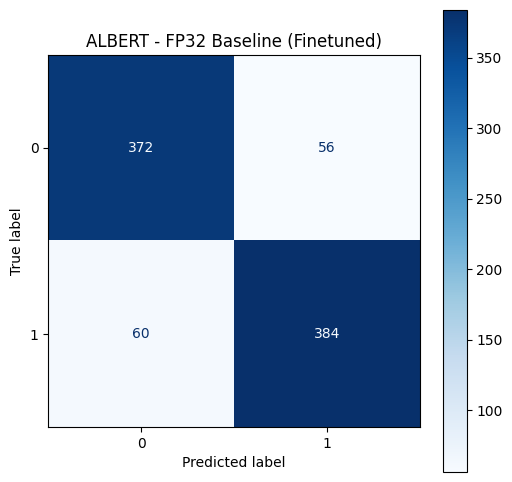

Applying quantization with Simple_INT8...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:01<00:00, 24.01it/s]


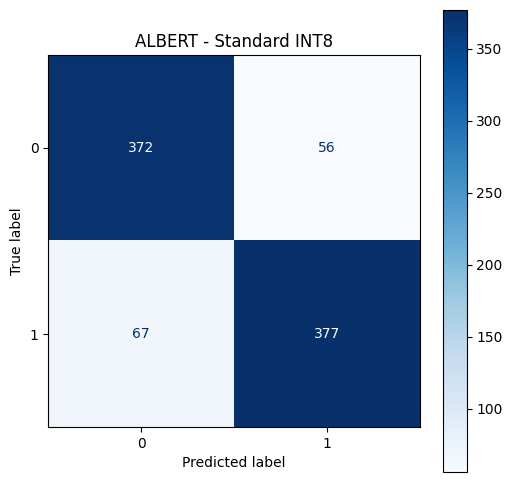

Applying quantization with AdaptivFloat_8bit_3exp...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:01<00:00, 24.82it/s]


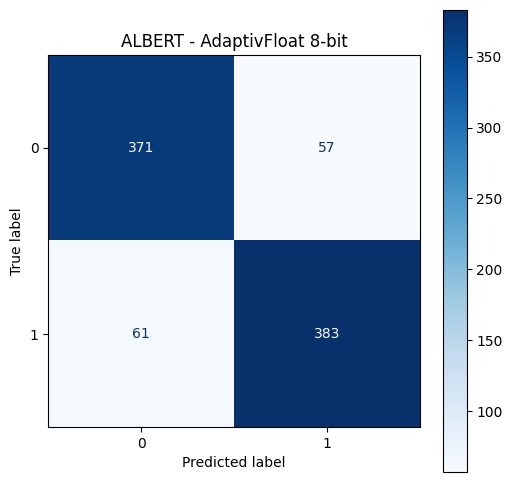


==================== COMPLETED ANALYSIS FOR: ALBERT ====================
All model comparisons complete.


In [22]:
import torch
import torch.nn as nn
import copy
from functools import partial
import pandas as pd

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW

from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm


# --- 1. Define Models and Datasets ---
model_names = [
    ("BERT-base", "bert-base-uncased"),
    ("DistilBERT", "distilbert-base-uncased"),
    ("ALBERT", "albert-base-v2")
]

# Load GLUE SST-2 Dataset
raw_dataset = load_dataset("glue", "sst2")
sst2_labels = [0, 1]  # 0 = negative, 1 = positive

# --- 2. Define Quantization Functions ---
quant_int8_func = partial(utils.simple_int8_quantizer, total_bits=8)
quant_int8_func.__name__ = "Simple_INT8"

quant_af8_func = partial(quantizer.quantize_to_adaptivfloat, total_bits=8, exponent_bits=3)
quant_af8_func.__name__ = "AdaptivFloat_8bit_3exp"


# --- 3. Main Experiment Loop ---
for model_display_name, model_hf_name in model_names:

    print(f"\n\n{'='*20} STARTING ANALYSIS FOR: {model_display_name} {'='*20}")

    # --- 3A: Load Model & Tokenizer ---
    print(f"Loading {model_hf_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_hf_name)
    model_fp32 = AutoModelForSequenceClassification.from_pretrained(model_hf_name, num_labels=2).to(device)

    # --- 3B: Tokenize Dataset ---
    def tokenize_fn(batch):
        return tokenizer(batch['sentence'], padding='max_length', truncation=True, max_length=128)

    tokenized_dataset = raw_dataset.map(tokenize_fn, batched=True)

    # RENAME label -> labels (very important)
    tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

    tokenized_dataset.set_format(
        type='torch',
        columns=['input_ids', 'attention_mask', 'labels']
    )

    train_dataloader = DataLoader(tokenized_dataset['train'], batch_size=16, shuffle=True)
    val_dataloader = DataLoader(tokenized_dataset['validation'], batch_size=32)

    # --- 3C: Log Activation Ranges (on untrained model) ---
    print(f"--- Logging FP32 Activation Ranges for {model_display_name} ---")
    activation_df = log_activation_ranges(model_fp32, val_dataloader, device)
    print(activation_df.head(10))

    # --- 3D: Fine-Tune the Model ---
    print(f"\n--- Fine-Tuning {model_display_name} on SST-2 ---")
    model_fp32.train()
    optimizer = AdamW(model_fp32.parameters(), lr=2e-5)
    num_epochs = 2

    for epoch in range(num_epochs):
        print(f"Starting Epoch {epoch + 1}/{num_epochs}")
        for batch in tqdm(train_dataloader, desc="Training"):
            optimizer.zero_grad()
            batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}
            outputs = model_fp32(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1} complete. Loss: {loss.item()}")

    model_fp32.eval()
    print("Fine-Tuning Complete.")

    # --- 3E: Run Quantization Tests ---
    print(f"\n--- Generating Confusion Matrices for {model_display_name} ---")

    # 1. FP32 Baseline
    y_true, y_pred_fp32 = get_all_predictions(model_fp32, val_dataloader, device)
    plot_confusion_matrix(y_true, y_pred_fp32, sst2_labels, f"{model_display_name} - FP32 Baseline (Finetuned)")

    # 2. Standard INT8
    model_int8 = copy.deepcopy(model_fp32).to(device)
    utils.apply_quantization_to_model(model_int8, quant_int8_func)
    y_true, y_pred_int8 = get_all_predictions(model_int8, val_dataloader, device)
    plot_confusion_matrix(y_true, y_pred_int8, sst2_labels, f"{model_display_name} - Standard INT8")

    # 3. AdaptivFloat 8-bit
    model_af8 = copy.deepcopy(model_fp32).to(device)
    utils.apply_quantization_to_model(model_af8, quant_af8_func)
    y_true, y_pred_af8 = get_all_predictions(model_af8, val_dataloader, device)
    plot_confusion_matrix(y_true, y_pred_af8, sst2_labels, f"{model_display_name} - AdaptivFloat 8-bit")

    print(f"\n{'='*20} COMPLETED ANALYSIS FOR: {model_display_name} {'='*20}")

print("All model comparisons complete.")


In [25]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader
from datasets import load_dataset # Make sure this is imported
import warnings

# --- 1. Define Models to Test (with CORRECTED IDs) ---
new_model_names = [
    # This is the correct model ID for the 4-layer TinyBERT
    ("TinyBERT (4L-312D)", "huawei-noah/TinyBERT_General_4L_312D"),
    
    # This is the correct model ID for MobileBERT
    ("MobileBERT", "google/mobilebert-uncased")
]

# (Assumes 'raw_dataset' (SST-2) is already loaded)
print("--- Starting Quick Investigation (Activation Ranges) ---")

# Suppress warnings from Hugging Face about untrained heads
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

for model_display_name, model_hf_name in new_model_names:
    
    print(f"\n{'='*20} ANALYZING: {model_display_name} {'='*20}")
    
    # --- 1A: Load Model & Tokenizer ---
    print(f"Loading {model_hf_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_hf_name)
    model_fp32 = AutoModelForSequenceClassification.from_pretrained(model_hf_name, num_labels=2).to(device)

    # --- 1B: Tokenize Dataset ---
    def tokenize_fn(batch):
        return tokenizer(batch['sentence'], padding='max_length', truncation=True, max_length=128)
    
    tokenized_dataset = raw_dataset.map(tokenize_fn, batched=True)
    tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    val_dataloader = DataLoader(tokenized_dataset['validation'], batch_size=32)
    
    # --- 1C: Log Activation Ranges ---
    print(f"--- Logging FP32 Activation Ranges for {model_display_name} ---")
    activation_df = log_activation_ranges(model_fp32, val_dataloader, device)
    
    # Print the top 10 most "wide-range" layers
    print(activation_df.head(10))

print("\nQuick investigation complete.")
# Turn warnings back on if you want
warnings.filterwarnings("default", category=UserWarning, module="transformers")

--- Starting Quick Investigation (Activation Ranges) ---

==================== ANALYZING: TinyBERT (4L-312D) ====================
Loading huawei-noah/TinyBERT_General_4L_312D...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1821/1821 [00:00<00:00, 19693.04 examples/s]


--- Logging FP32 Activation Ranges for TinyBERT (4L-312D) ---
Logging activation ranges for BertForSequenceClassification...
Logging complete.
                                                 Min          Max  \
bert.encoder.layer.0.output.dense         -63.271923  4463.749023   
bert.encoder.layer.2.output.dense         -97.573494    66.649178   
bert.encoder.layer.0.intermediate.dense   -85.213219    69.652679   
bert.encoder.layer.1.intermediate.dense   -26.056356     7.224613   
bert.encoder.layer.0.attention.self.key   -13.509913     9.542007   
bert.encoder.layer.0.attention.self.query -10.141545    11.543982   
bert.encoder.layer.2.intermediate.dense   -10.352216     6.012820   
bert.encoder.layer.3.intermediate.dense    -9.846236     5.137727   
bert.encoder.layer.1.attention.self.value  -7.094005     6.795686   
bert.encoder.layer.1.attention.self.query  -7.198825     5.998433   

                                           Dynamic Range (Max - Min)  
bert.encoder.layer.0.outpu

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1821/1821 [00:00<00:00, 19494.30 examples/s]


--- Logging FP32 Activation Ranges for MobileBERT ---
Logging activation ranges for MobileBertForSequenceClassification...
Logging complete.
                                                             Min  \
mobilebert.encoder.layer.23.output.bottleneck.d... -6.541615e+07   
mobilebert.encoder.layer.23.output.dense           -4.419365e+07   
mobilebert.encoder.layer.23.intermediate.dense     -1.399119e+06   
mobilebert.encoder.layer.23.intermediate.interm...  0.000000e+00   
classifier                                         -5.561756e+06   
mobilebert.encoder.layer.23.ffn.2.output.dense     -2.138628e+06   
mobilebert.encoder.layer.23.ffn.2.intermediate.... -3.460822e+05   
mobilebert.encoder.layer.23.ffn.2.intermediate....  0.000000e+00   
mobilebert.encoder.layer.23.ffn.1.output.dense     -5.133653e+05   
mobilebert.encoder.layer.23.ffn.1.intermediate.... -1.182615e+04   

                                                             Max  \
mobilebert.encoder.layer.23.output.bottlen

In [32]:
@torch.no_grad()
def get_all_predictions(model, dataloader, device):
    """
    (CORRECTED VERSION)
    Runs a model over a test dataloader and returns all predictions and labels.
    Handles both list-style (MNIST) and dict-style (BERT) dataloaders.
    """
    model.eval()
    all_preds = []
    all_labels = []
    print("Gathering all predictions for confusion matrix...")
    
    for batch in tqdm(dataloader, desc="Predicting"):
        
        # --- 1. Handle LIST (MNIST) vs DICT (BERT) ---
        if isinstance(batch, list):
            # MNIST/CIFAR style: batch is [data, labels]
            data, labels = batch
            data, labels = data.to(device), labels.to(device)
            # This is the input for the model
            model_input = data 
            
        elif isinstance(batch, dict):
            # BERT/SST-2 style: batch is a dict
            
            # --- THIS IS THE FIX ---
            # 1. Pop the 'label' key to get the true labels.
            #    This also REMOVES it from the batch dict.
            labels = batch.pop('label').to(device)
            
            # 2. The remaining batch is the input for the model
            model_input = {k: v.to(device) for k, v in batch.items()}
            
        else:
            raise TypeError(f"Unknown batch type: {type(batch)}")
            
        # --- 2. Get Model Output ---
        if isinstance(model_input, dict): # BERT model
            outputs = model(**model_input)
        else: # MNIST/CNN model
            outputs = model(model_input)
        
        # --- 3. Get Predictions ---
        if isinstance(outputs, torch.Tensor):
            pred = torch.argmax(outputs, dim=1)
        else:
            pred = torch.argmax(outputs.logits, dim=1)
            
        # --- 4. Store results ---
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
    return all_labels, all_preds



==================== STARTING FULL TEST FOR: TinyBERT (4L-312D) ====================
Loading huawei-noah/TinyBERT_General_4L_312D...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Fine-Tuning TinyBERT (4L-312D) on SST-2 ---
Starting Epoch 1/2


Training: 100%|██████████| 4210/4210 [00:30<00:00, 139.44it/s]


Epoch 1 complete. Loss: 0.06750015914440155
Starting Epoch 2/2


Training: 100%|██████████| 4210/4210 [00:30<00:00, 139.25it/s]


Epoch 2 complete. Loss: 0.030087459832429886
Fine-Tuning Complete.

--- Generating Confusion Matrices for TinyBERT (4L-312D) ---
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:00<00:00, 256.51it/s]


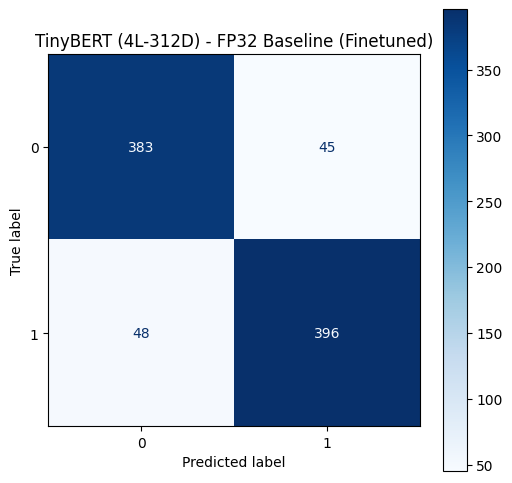

Applying quantization with Simple_INT8...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:00<00:00, 165.74it/s]


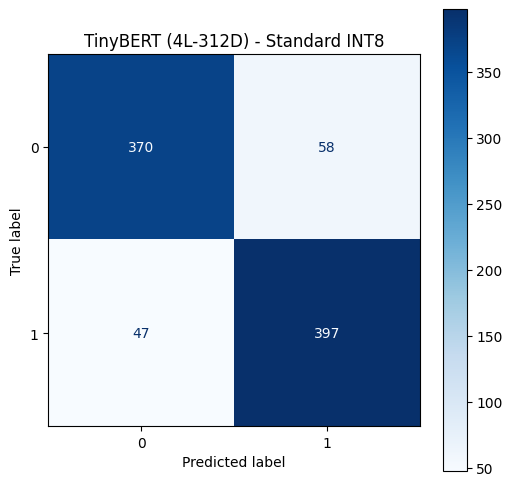

Applying quantization with AdaptivFloat_8bit_3exp...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:00<00:00, 188.84it/s]


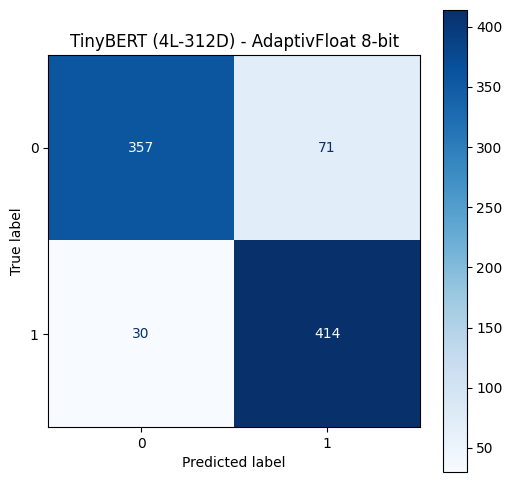


==================== COMPLETED ANALYSIS FOR: TinyBERT (4L-312D) ====================


==================== STARTING FULL TEST FOR: MobileBERT ====================
Loading google/mobilebert-uncased...


Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 872/872 [00:00<00:00, 17791.41 examples/s]



--- Fine-Tuning MobileBERT on SST-2 ---
Starting Epoch 1/2


Training: 100%|██████████| 4210/4210 [04:37<00:00, 15.20it/s]


Epoch 1 complete. Loss: 0.820692241191864
Starting Epoch 2/2


Training: 100%|██████████| 4210/4210 [04:28<00:00, 15.69it/s]


Epoch 2 complete. Loss: 0.4057620167732239
Fine-Tuning Complete.

--- Generating Confusion Matrices for MobileBERT ---
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:00<00:00, 62.68it/s]


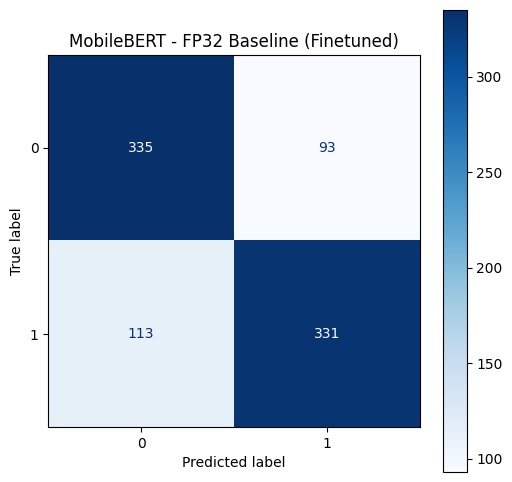

Applying quantization with Simple_INT8...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:00<00:00, 63.07it/s]


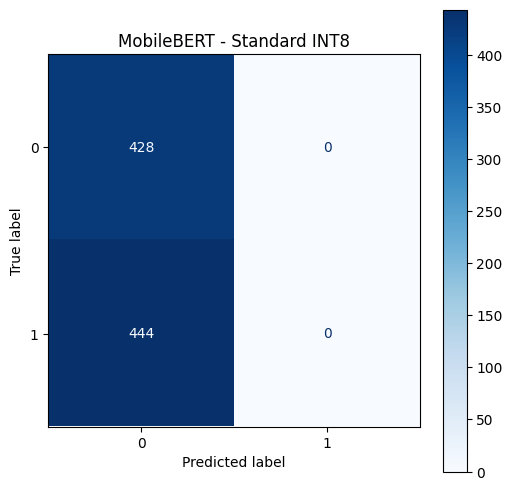

Applying quantization with AdaptivFloat_8bit_3exp...
Quantization complete.
Gathering all predictions for confusion matrix...


Predicting: 100%|██████████| 28/28 [00:00<00:00, 63.03it/s]


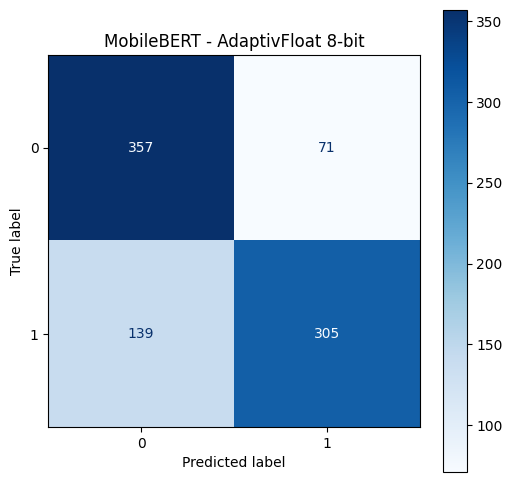


==================== COMPLETED ANALYSIS FOR: MobileBERT ====================
All model comparisons complete.


In [33]:
import torch
import torch.nn as nn
import copy
from functools import partial
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

# --- 1. Define Models and Datasets ---
# (Using the corrected, working model names)
models_to_test = [
    ("TinyBERT (4L-312D)", "huawei-noah/TinyBERT_General_4L_312D"),
    ("MobileBERT", "google/mobilebert-uncased")
]

# (Assumes 'raw_dataset' (SST-2) is already loaded)
sst2_labels = [0, 1] # 0 = negative, 1 = positive

# --- 2. Define Quantization Functions (for testing later) ---
quant_int8_func = partial(utils.simple_int8_quantizer, total_bits=8)
quant_int8_func.__name__ = "Simple_INT8"

quant_af8_func = partial(quantizer.quantize_to_adaptivfloat, total_bits=8, exponent_bits=3)
quant_af8_func.__name__ = "AdaptivFloat_8bit_3exp"

# --- 3. Main Experiment Loop ---
for model_display_name, model_hf_name in models_to_test:
    
    print(f"\n\n{'='*20} STARTING FULL TEST FOR: {model_display_name} {'='*20}")
    
    # --- 3A: Load Model & Tokenizer ---
    print(f"Loading {model_hf_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_hf_name)
    model_fp32 = AutoModelForSequenceClassification.from_pretrained(model_hf_name, num_labels=2).to(device)

    # --- 3B: Tokenize Dataset ---
    def tokenize_fn(batch):
        return tokenizer(batch['sentence'], padding='max_length', truncation=True, max_length=128)
    
    tokenized_dataset = raw_dataset.map(tokenize_fn, batched=True)
    tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    
    train_dataloader = DataLoader(tokenized_dataset['train'], batch_size=16, shuffle=True)
    val_dataloader = DataLoader(tokenized_dataset['validation'], batch_size=32)
    
    # --- 3C: Fine-Tune the Model ---
    print(f"\n--- Fine-Tuning {model_display_name} on SST-2 ---")
    model_fp32.train()
    optimizer = AdamW(model_fp32.parameters(), lr=2e-5)
    num_epochs = 2 # 2 epochs is enough
    
    for epoch in range(num_epochs):
        print(f"Starting Epoch {epoch + 1}/{num_epochs}")
        for batch in tqdm(train_dataloader, desc="Training"):
            optimizer.zero_grad()
            batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'label']}
            if 'label' in batch:
                batch['labels'] = batch.pop('label')
            outputs = model_fp32(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1} complete. Loss: {loss.item()}")
    
    model_fp32.eval() # Set to eval mode
    print("Fine-Tuning Complete.")
    
    # --- 3D: Run Quantization & Confusion Matrix Tests ---
    print(f"\n--- Generating Confusion Matrices for {model_display_name} ---")
    
    # 1. FP32 Baseline
    y_true, y_pred_fp32 = get_all_predictions(model_fp32, val_dataloader, device)
    plot_confusion_matrix(y_true, y_pred_fp32, sst2_labels, f"{model_display_name} - FP32 Baseline (Finetuned)")
    
    # 2. Standard INT8
    model_int8 = copy.deepcopy(model_fp32).to(device)
    utils.apply_quantization_to_model(model_int8, quant_int8_func)
    y_true, y_pred_int8 = get_all_predictions(model_int8, val_dataloader, device)
    plot_confusion_matrix(y_true, y_pred_int8, sst2_labels, f"{model_display_name} - Standard INT8")
    
    # 3. AdaptivFloat 8-bit
    model_af8 = copy.deepcopy(model_fp32).to(device)
    utils.apply_quantization_to_model(model_af8, quant_af8_func)
    y_true, y_pred_af8 = get_all_predictions(model_af8, val_dataloader, device)
    plot_confusion_matrix(y_true, y_pred_af8, sst2_labels, f"{model_display_name} - AdaptivFloat 8-bit")
    
    print(f"\n{'='*20} COMPLETED ANALYSIS FOR: {model_display_name} {'='*20}")

print("All model comparisons complete.")